Library


In [26]:
import numpy as np
import math
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import optuna

# Dataset Inference


## Load


Dir


In [2]:
MAIN_PATH = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# MAIN_PATH = 

Raw


In [3]:
with open(MAIN_PATH + r"\Dataset\dataset_preprocessed.pkl", "rb") as f:
    dataset = pickle.load(f)

In [4]:
len(dataset)

793

Normalisasi, Split, dan Batching


In [17]:
X = [[data[3], data[4]] for data in dataset]
original_labels = [int(data[2]) for data in dataset]
y = [1 if label in (0, 1) else 2 for label in original_labels]

scl = StandardScaler()
X = scl.fit_transform(X)

## Analisa Statistik


In [18]:
t1 = 0
t2 = 0
for i in y:
    if i == 1:
        t1 += 1
    else:
        t2 += 1

print(t1, t2)

332 461


Describe


In [19]:
df_raw = pd.DataFrame(X, columns=['rms', 'zcr'])
df_raw['label'] = y

In [20]:
for label in df_raw['label'].unique():
    print(f"Label: {label}")
    display(df_raw[df_raw['label'] == label].describe().T)

Label: 2


,count,mean,std,min,25%,50%,75%,max
rms,461.0,-0.412966,0.442953,-0.749020,-0.710298,-0.599982,-0.292298,2.503502
zcr,461.0,-0.238970,1.033953,-1.529042,-1.237242,-0.277819,0.628462,1.987644
label,461.0,2.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000


Label: 1


,count,mean,std,min,25%,50%,75%,max
rms,332.0,0.573426,1.247303,-0.699480,-0.253993,0.240114,0.807338,5.497620
zcr,332.0,0.331823,0.848585,-1.436404,-0.214444,0.484836,0.920023,1.972085
label,332.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Visualization


<Axes: title={'center': 'rms'}, xlabel='label'>

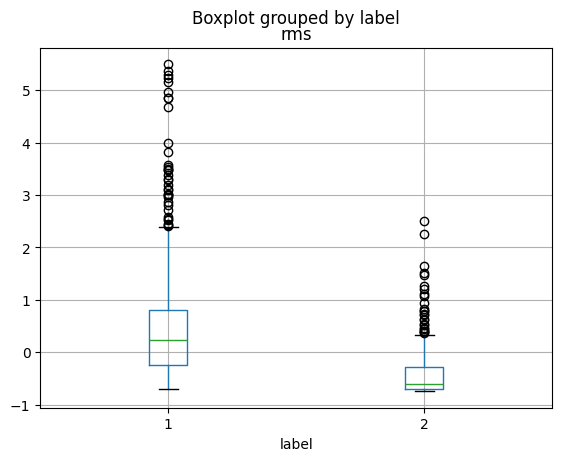

In [21]:
df_raw.boxplot(column=['rms'], by='label')

<Axes: title={'center': 'zcr'}, xlabel='label'>

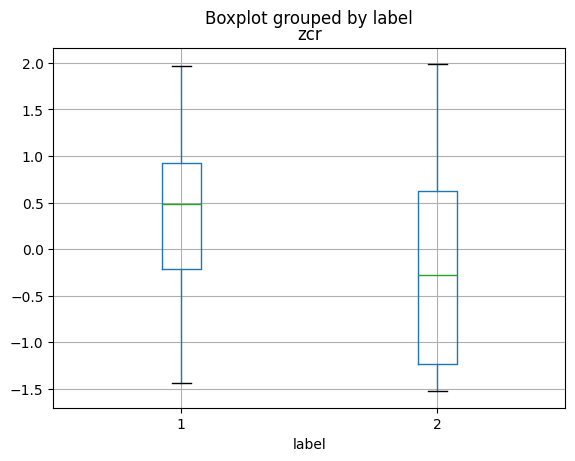

In [22]:
df_raw.boxplot(column=['zcr'], by='label')

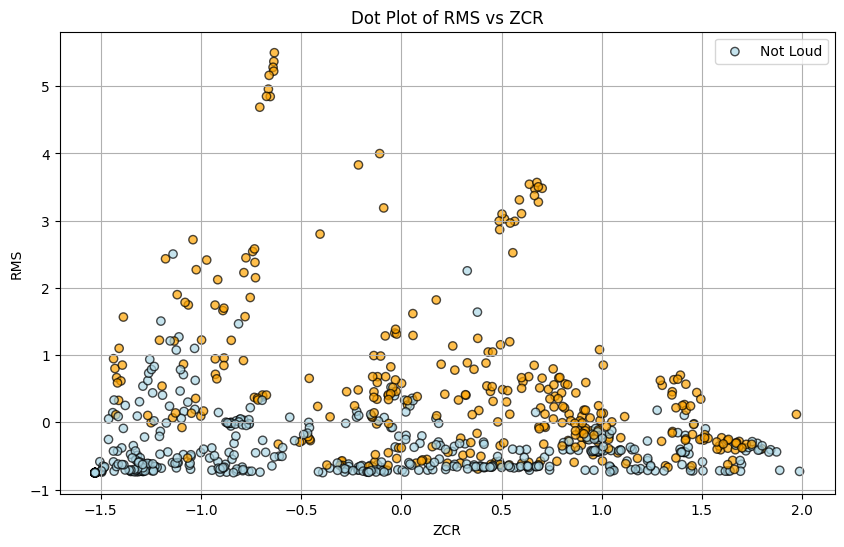

In [23]:
colors = df_raw['label'].map({2: 'lightblue', 1: 'orange'})

plt.figure(figsize=(10, 6))
plt.scatter(df_raw['zcr'], df_raw['rms'], c=colors, alpha=0.7, edgecolors='k')
plt.xlabel('ZCR')
plt.ylabel('RMS')
plt.title('Dot Plot of RMS vs ZCR')
plt.grid(True)
plt.legend(labels=['Not Loud', 'Loud'])
plt.show()

Hyperparameters


In [ ]:
RMS_LOW_C = 0.0168545
RMS_LOW_S = 296.65667922513273

RMS_MEDIUM_M = 0.048329
RMS_MEDIUM_S = 0.036058598726114645

RMS_HIGH_C = 0.229253
RMS_HIGH_S = 22.827402013376858


ZCR_INFREQ_C = 4614.5
ZCR_INFREQ_S = 0.0010835410120273053

ZCR_MODERATE_M = 6150.125
ZCR_MODERATE_S = 4031.5286624203823

ZCR_FREQ_C = 10328.875
ZCR_FREQ_S = 0.0011462303349858154


LOUD_C = 0.8
LOUD_S = 25.0

NOT_LOUD_C = 0.2
NOT_LOUD_S = 25.0

# Fuzzy dan Fungsi


Membership Functions


In [ ]:
def sigmf(x, c, s):
    return 1 / (1 + math.exp(-s * (x - c)))

def gaussmf(x, m, s):
    return math.exp(-((x - m) ** 2) / (2 * s ** 2))

Fuzzy Sets


In [ ]:
def fuzzify_rms(val):
    return {
        'low': sigmf(val, RMS_LOW_C, RMS_LOW_S),
        'medium': gaussmf(val, RMS_MEDIUM_M, RMS_MEDIUM_S),
        'high': sigmf(val, RMS_HIGH_C, RMS_HIGH_S)
    }

def fuzzify_zcr(val):
    return {
        'infrequent': sigmf(val, ZCR_INFREQ_C, ZCR_INFREQ_S),
        'moderate': gaussmf(val, ZCR_MODERATE_M, ZCR_MODERATE_S),
        'frequent': sigmf(val, ZCR_FREQ_C, ZCR_FREQ_S)
    }

## Fuzzy Inference System


### Mamdani Inference Engine


In [ ]:
def mamdani_rule_evaluation(rms_set, zcr_set):
    return [
        ('not_loud', min(rms_set['low'], zcr_set['infrequent'])),
        ('not_loud', min(rms_set['low'], zcr_set['moderate'])),
        ('not_loud', min(rms_set['low'], zcr_set['frequent'])),
        ('not_loud', min(rms_set['medium'], zcr_set['infrequent'])),
        ('not_loud', min(rms_set['medium'], zcr_set['moderate'])),
        ('loud', min(rms_set['medium'], zcr_set['frequent'])),
        ('loud', min(rms_set['high'], zcr_set['infrequent'])),
        ('loud', min(rms_set['high'], zcr_set['moderate'])),
        ('loud', min(rms_set['high'], zcr_set['frequent']))
    ]

def mamdani_aggregate(rules):
    loud_dom = [s for l, s in rules if l == 'loud']
    not_loud_dom = [s for l, s in rules if l == 'not_loud']
    return max(loud_dom) if loud_dom else 0, max(not_loud_dom) if not_loud_dom else 0

def mamdani_defuzzify(loud, not_loud):
    output_range = np.linspace(0, 1, 101)
    numerator = 0
    denominator = 0
    for o in output_range:
        mu = max(
            min(sigmf(o, LOUD_C, LOUD_S), loud),
            min(sigmf(o, NOT_LOUD_C, NOT_LOUD_S), not_loud)
        )
        numerator += o * mu
        denominator += mu
    return numerator / denominator if denominator != 0 else 0

def fuzzy_mamdani_infer(rms_val, zcr_val):
    rms_set = fuzzify_rms(rms_val)
    zcr_set = fuzzify_zcr(zcr_val)
    rules = mamdani_rule_evaluation(rms_set, zcr_set)
    loud, not_loud = mamdani_aggregate(rules)
    return mamdani_defuzzify(loud, not_loud)

### Sugeno Inference Engine


In [ ]:
def sugeno_rule_evaluation(rms_set, zcr_set):
    return [
        (min(rms_set['low'], zcr_set['infrequent']), 0.0),
        (min(rms_set['low'], zcr_set['moderate']), 0.0),
        (min(rms_set['low'], zcr_set['frequent']), 0.0),
        (min(rms_set['medium'], zcr_set['infrequent']), 0.0),
        (min(rms_set['medium'], zcr_set['moderate']), 0.0),
        (min(rms_set['medium'], zcr_set['frequent']), 1.0),
        (min(rms_set['high'], zcr_set['infrequent']), 1.0),
        (min(rms_set['high'], zcr_set['moderate']), 1.0),
        (min(rms_set['high'], zcr_set['frequent']), 1.0)
    ]

def sugeno_weighted_average(rules):
    numerator = sum(w * z for w, z in rules)
    denominator = sum(w for w, _ in rules)
    return numerator / denominator if denominator != 0 else 0

def fuzzy_sugeno_infer(rms_val, zcr_val):
    rms_set = fuzzify_rms(rms_val)
    zcr_set = fuzzify_zcr(zcr_val)
    rules = sugeno_rule_evaluation(rms_set, zcr_set)
    return sugeno_weighted_average(rules)

## Classification


In [ ]:
def classify_output(output):
    return 1 if output >= 0.5 else 2

def classify_mamdani(rms_val, zcr_val):
    output = fuzzy_mamdani_infer(rms_val, zcr_val)
    return classify_output(output)

def classify_sugeno(rms_val, zcr_val):
    output = fuzzy_sugeno_infer(rms_val, zcr_val)
    return classify_output(output)

# Example


Label 1 (Suara Keras)


In [ ]:
rms_val = 0.07
zcr_val = 9000

print(classify_mamdani(rms_val, zcr_val))
print(classify_sugeno(rms_val, zcr_val))

1
2


Label 2 (Suara Background)


In [ ]:
rms_val = 0.7
zcr_val = 9000

print(classify_mamdani(rms_val, zcr_val))
print(classify_sugeno(rms_val, zcr_val))

1
1


# Inference


In [ ]:
# Inference
y_mamdani = []
y_sugeno = []

for (rms, zcr) in X:
    y_mamdani.append(classify_mamdani(rms, zcr))
    y_sugeno.append(classify_sugeno(rms, zcr))

# Evaluate
print("Mamdani")
print(f"Accuracy: {accuracy_score(y, y_mamdani)}")
print(f"Precision: {precision_score(y, y_mamdani)}")
print(f"Recall: {recall_score(y, y_mamdani)}")
print(f"F1-Score: {f1_score(y, y_mamdani)}")
print(f"Confusion Matrix:\n {confusion_matrix(y, y_mamdani)}")

print("\nSugeno")
print(f"Accuracy: {accuracy_score(y, y_sugeno)}")
print(f"Precision: {precision_score(y, y_sugeno)}")
print(f"Recall: {recall_score(y, y_sugeno)}")
print(f"F1-Score: {f1_score(y, y_sugeno)}")
print(f"Confusion Matrix:\n {confusion_matrix(y, y_sugeno)}")

Mamdani
Accuracy: 0.6897856242118537
Precision: 0.6897856242118537
Recall: 1.0
F1-Score: 0.8164179104477612
Confusion Matrix:
 [[547   0]
 [246   0]]

Sugeno
Accuracy: 0.32156368221941994
Precision: 1.0
Recall: 0.016453382084095063
F1-Score: 0.03237410071942446
Confusion Matrix:
 [[  9 538]
 [  0 246]]


# Optuna


In [24]:
def optimize_fuzzy(trial):
    RMS_LOW_C = trial.suggest_float("RMS_LOW_C", 0.0, 0.03)
    RMS_LOW_S = trial.suggest_float("RMS_LOW_S", 100, 600)

    RMS_MEDIUM_M = trial.suggest_float("RMS_MEDIUM_M", 0.02, 0.07)
    RMS_MEDIUM_S = trial.suggest_float("RMS_MEDIUM_S", 0.005, 0.05)

    RMS_HIGH_C = trial.suggest_float("RMS_HIGH_C", 0.08, 0.3)
    RMS_HIGH_S = trial.suggest_float("RMS_HIGH_S", 5, 40)

    ZCR_INFREQ_C = trial.suggest_float("ZCR_INFREQ_C", 1000, 6000)
    ZCR_INFREQ_S = trial.suggest_float("ZCR_INFREQ_S", 0.0005, 0.005)

    ZCR_MODERATE_M = trial.suggest_float("ZCR_MODERATE_M", 3000, 9000)
    ZCR_MODERATE_S = trial.suggest_float("ZCR_MODERATE_S", 1000, 7000)

    ZCR_FREQ_C = trial.suggest_float("ZCR_FREQ_C", 8000, 15000)
    ZCR_FREQ_S = trial.suggest_float("ZCR_FREQ_S", 0.0005, 0.005)

    LOUD_C = trial.suggest_float("LOUD_C", 0.5, 1.0)
    LOUD_S = trial.suggest_float("LOUD_S", 10, 50)

    NOT_LOUD_C = trial.suggest_float("NOT_LOUD_C", 0.0, 0.4)
    NOT_LOUD_S = trial.suggest_float("NOT_LOUD_S", 10, 50)

    def sigmf(x, c, s):
        return 1 / (1 + math.exp(-s * (x - c)))

    def gaussmf(x, m, s):
        return math.exp(-((x - m) ** 2) / (2 * s ** 2))

    def fuzzify_rms(val):
        return {
            'low': sigmf(val, RMS_LOW_C, RMS_LOW_S),
            'medium': gaussmf(val, RMS_MEDIUM_M, RMS_MEDIUM_S),
            'high': sigmf(val, RMS_HIGH_C, RMS_HIGH_S)
        }

    def fuzzify_zcr(val):
        return {
            'infrequent': sigmf(val, ZCR_INFREQ_C, ZCR_INFREQ_S),
            'moderate': gaussmf(val, ZCR_MODERATE_M, ZCR_MODERATE_S),
            'frequent': sigmf(val, ZCR_FREQ_C, ZCR_FREQ_S)
        }

    def mamdani_rule_evaluation(rms_set, zcr_set):
        return [
            ('not_loud', min(rms_set['low'], zcr_set['infrequent'])),
            ('not_loud', min(rms_set['low'], zcr_set['moderate'])),
            ('not_loud', min(rms_set['low'], zcr_set['frequent'])),
            ('not_loud', min(rms_set['medium'], zcr_set['infrequent'])),
            ('not_loud', min(rms_set['medium'], zcr_set['moderate'])),
            ('loud', min(rms_set['medium'], zcr_set['frequent'])),
            ('loud', min(rms_set['high'], zcr_set['infrequent'])),
            ('loud', min(rms_set['high'], zcr_set['moderate'])),
            ('loud', min(rms_set['high'], zcr_set['frequent']))
        ]

    def mamdani_aggregate(rules):
        loud_dom = [s for l, s in rules if l == 'loud']
        not_loud_dom = [s for l, s in rules if l == 'not_loud']
        return max(loud_dom) if loud_dom else 0, max(not_loud_dom) if not_loud_dom else 0

    def mamdani_defuzzify(loud, not_loud):
        output_range = np.linspace(0, 1, 101)
        numerator = 0
        denominator = 0
        for o in output_range:
            mu = max(
                min(sigmf(o, LOUD_C, LOUD_S), loud),
                min(sigmf(o, NOT_LOUD_C, NOT_LOUD_S), not_loud)
            )
            numerator += o * mu
            denominator += mu
        return numerator / denominator if denominator != 0 else 0

    def fuzzy_mamdani_infer(rms_val, zcr_val):
        rms_set = fuzzify_rms(rms_val)
        zcr_set = fuzzify_zcr(zcr_val)
        rules = mamdani_rule_evaluation(rms_set, zcr_set)
        loud, not_loud = mamdani_aggregate(rules)
        return mamdani_defuzzify(loud, not_loud)

    def classify_output(output):
        return 1 if output >= 0.5 else 2

    def classify_mamdani(rms_val, zcr_val):
        output = fuzzy_mamdani_infer(rms_val, zcr_val)
        return classify_output(output)

    y_mamdani = [classify_mamdani(rms, zcr) for rms, zcr in X]
    score = f1_score(y, y_mamdani)
    return score

In [ ]:
# [I 2025-05-15 10:29:42,686] Trial 440 finished with value: 0.8330733229329174 and parameters: {'RMS_LOW_C': 0.021385268838932454, 'RMS_LOW_S': 170.58823145759033, 'RMS_MEDIUM_M': 0.046375479902471636, 'RMS_MEDIUM_S': 0.00501027974247247, 'RMS_HIGH_C': 0.2753180384748499, 'RMS_HIGH_S': 12.002275095623094, 'ZCR_INFREQ_C': 2493.1656190114886, 'ZCR_INFREQ_S': 0.0008620631418804517, 'ZCR_MODERATE_M': 4782.852668951398, 'ZCR_MODERATE_S': 4757.887314646938, 'ZCR_FREQ_C': 14748.051615194798, 'ZCR_FREQ_S': 0.004670963030780051, 'LOUD_C': 0.9335071916290064, 'LOUD_S': 42.770147326791694, 'NOT_LOUD_C': 0.1901805921119046, 'NOT_LOUD_S': 11.826406346881223}. Best is trial 440 with value: 0.8330733229329174.

In [27]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_fuzzy, n_trials=5000)

print("Best F1 Score:", study.best_value)
print("Best Parameters:", study.best_params)

[I 2025-05-15 22:56:31,175] A new study created in memory with name: no-name-1785b356-d5d8-4553-946e-9faeeee55e37
[I 2025-05-15 22:56:31,309] Trial 0 finished with value: 0.5902222222222222 and parameters: {'RMS_LOW_C': 0.021407693436327237, 'RMS_LOW_S': 196.10872938104941, 'RMS_MEDIUM_M': 0.029880850373951384, 'RMS_MEDIUM_S': 0.011143567105949763, 'RMS_HIGH_C': 0.291958202377653, 'RMS_HIGH_S': 13.988012645864927, 'ZCR_INFREQ_C': 5393.841566071874, 'ZCR_INFREQ_S': 0.0019215444178848858, 'ZCR_MODERATE_M': 7245.476139920007, 'ZCR_MODERATE_S': 1722.047823693254, 'ZCR_FREQ_C': 11412.861016081217, 'ZCR_FREQ_S': 0.0045699614913976404, 'LOUD_C': 0.7927718903402172, 'LOUD_S': 35.07521947917514, 'NOT_LOUD_C': 0.34465802704900234, 'NOT_LOUD_S': 47.89761106062338}. Best is trial 0 with value: 0.5902222222222222.
[I 2025-05-15 22:56:31,438] Trial 1 finished with value: 0.6080808080808081 and parameters: {'RMS_LOW_C': 0.004772990263495924, 'RMS_LOW_S': 152.67652511929228, 'RMS_MEDIUM_M': 0.04642656

KeyboardInterrupt: 